在沙盒环境，计算标的 趋势变化敏感速度及标的之间相关性

In [1]:
import os, copy, sys
os.environ['ULTRON_DATA'] = 'keim'
os.environ['IGNORE_WARNINGS'] = '0'
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from ultron.ump.technical.exectue import calc_pair_speed
from ultron.ump.market.symbol_pd import _benchmark
from ultron.kdutils.scaler import scaler_one
from ultron.ump.core.helper import pd_resample

/var/log/ultron/2022-10-03.log


In [3]:
from ultron.env import *

In [4]:
enable_example_env()

2022-10-03 20:20:11,546 - [env.py:81] - ultron - INFO - enable example env will only read /home/kerry/ultron/rom/sandbox/keim


In [5]:
market_data = pd.read_csv(os.path.join(g_project_data, 'market_data.csv'), index_col=0)
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

In [6]:
def next_returs_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = np.log(price_tb.shift(-1) / price_tb)
    return_tb = return_tb.replace([np.inf, -np.inf], np.nan)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [7]:
def pre_close_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = price_tb.shift(-1)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [8]:
next_rets = next_returs_impl(
    market_data.set_index(['trade_date','code']),'closePrice','nxt1_ret').reset_index()
next_rets['trade_date'] = pd.to_datetime(next_rets['trade_date'])
next_rets.head()

,trade_date,code,nxt1_ret
0,2017-10-27,A,-0.0003
1,2017-10-27,AL,0.0012
2,2017-10-27,BU,0.0199
3,2017-10-27,C,-0.0054
4,2017-10-27,CF,0.0010


In [9]:
pre_close = pre_close_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre_close').reset_index()
pre_close['trade_date'] = pd.to_datetime(pre_close['trade_date'])
pre_close.head()

,trade_date,code,pre_close
0,2017-10-27,A,4434.4424
1,2017-10-27,AL,15468.8167
2,2017-10-27,BU,3368.8829
3,2017-10-27,C,1991.7101
4,2017-10-27,CF,20469.6218


In [10]:
market_data = market_data.merge(next_rets, on=['trade_date','code']).merge(
    pre_close, on=['trade_date','code'])
market_data['date'] = pd.to_datetime(market_data['trade_date'])
market_data = market_data.set_index('trade_date')
market_data = market_data.rename(columns={
    'openPrice':'open','closePrice':'close',
    'highestPrice':'high','lowestPrice':'low',
    'turnoverVol':'volume','nxt1_ret':'p_change'})
market_data['p_change'] = market_data['p_change'] * 100
market_data = market_data[['code','date','pre_close','open','high','low','close','p_change','volume']]
market_data.head()

,code,date,pre_close,open,high,low,close,p_change,volume
trade_date,,,,,,,,,
2017-10-27,A,2017-10-27,4434.4424,4462.5782,4463.8015,4413.6464,4435.6657,-0.0276,158774
2017-10-27,AL,2017-10-27,15468.8167,15625.6586,15658.9047,15430.9315,15449.9293,0.1222,293630
2017-10-27,BU,2017-10-27,3368.8829,3310.3399,3336.9504,3283.7295,3302.3568,1.9945,461826
2017-10-27,C,2017-10-27,1991.7101,2009.7510,2014.5619,2001.3319,2002.5347,-0.5420,375480
2017-10-27,CF,2017-10-27,20469.6218,20517.4960,20531.1743,20408.0694,20449.1043,0.1003,84032


以黑色系的RB和I为例

In [11]:
kl = market_data.reset_index().set_index('code').loc['RB'].set_index('trade_date')
benchmark_kl = market_data.reset_index().set_index('code').loc['I'].set_index('trade_date')
benchmark_kl = benchmark_kl[-252:]

##### 数据对齐

In [12]:
kl = _benchmark(kl, benchmark_kl)
kl.head()

,date,pre_close,open,high,low,close,p_change,volume,date_week
trade_date,,,,,,,,,
2021-06-08,20210608,4650.6814,4572.1694,4636.8263,4528.7569,4622.0476,0.6176,2189390,1
2021-06-09,20210609,4773.5296,4622.0476,4710.7200,4597.1085,4650.6814,2.6072,1898245,2
2021-06-10,20210610,4915.7748,4655.2997,4804.9344,4652.5287,4773.5296,2.9363,2386753,3
2021-06-11,20210611,4773.5296,4794.7740,4923.1642,4789.2320,4915.7748,-2.9363,2032513,4
2021-06-15,20210615,4631.2843,4803.0870,4828.9498,4719.9567,4773.5296,-3.0252,1761824,1


##### 敏感度计算

根据分析，一般来说相关计算采用收盘价，但也可以自定义其他行情价格计算

指定收盘价为相关性计算

RB 趋势变化敏感速度:0.5733333333333334, I 趋势变化敏感速度:0.5466666666666666, RB与I相关度:0.5930566949489439, RB与I趋势相关敏感速度差0.01581484519863854, 重采样:5


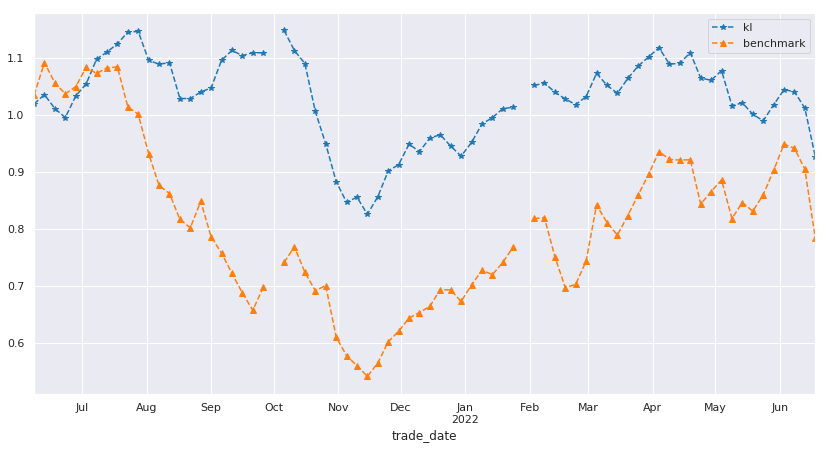

In [13]:
name = 'open'
resample = 5
kl_speed, benchmark_kl_speed, corr = calc_pair_speed(
    kl=kl[name],benchmark_kl=benchmark_kl[name], 
    kl_close=kl['close'],benchmark_close=benchmark_kl['close'],
    resample=5)
print(
    "RB 趋势变化敏感速度:{0}, I 趋势变化敏感速度:{1}, RB与I相关度:{2}, RB与I趋势相关敏感速度差{3}, 重采样:{4}".format(
    kl_speed, benchmark_kl_speed, corr, (kl_speed-benchmark_kl_speed) * corr, resample))
plt.figure(figsize=(14, 7))
kl_sl = scaler_one(kl[name])
benchmark_kl_sl = scaler_one(benchmark_kl[name])
kl_resamp = pd_resample(kl_sl, '{}D'.format(5), how='mean')
benchmark_kl_resamp = pd_resample(benchmark_kl_sl,
                                              '{}D'.format(5),
                                              how='mean')
kl_resamp.plot(label='kl', style=['*--'])
benchmark_kl_resamp.plot(label='benchmark', style=['^--'])
plt.legend(loc='best')

不指定收盘价为相关性计算，则采用敏感度价格作为相关性计算

RB 趋势变化敏感速度:0.6, I 趋势变化敏感速度:0.6266666666666667, RB与I相关度:0.5844809841360213, RB与I趋势相关敏感速度差:-0.015586159576960605, 重采样:5


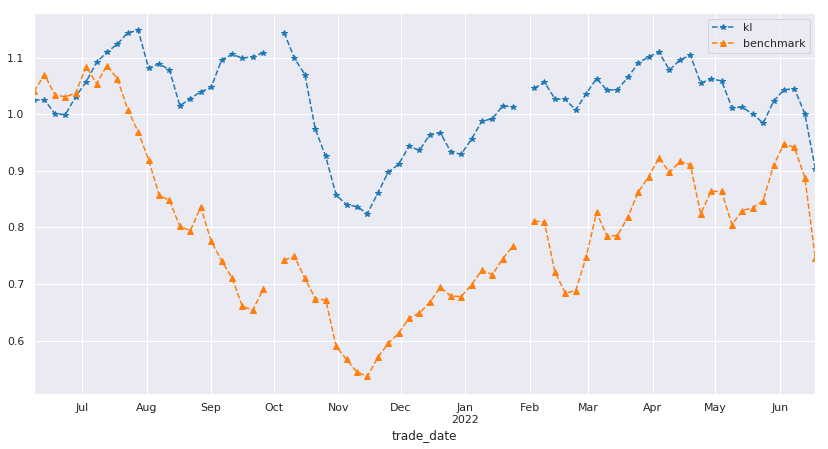

In [14]:
name = 'low'
resample = 5
kl_speed, benchmark_kl_speed, corr = calc_pair_speed(
    kl=kl[name],benchmark_kl=benchmark_kl[name], resample=resample)
print(
    "RB 趋势变化敏感速度:{0}, I 趋势变化敏感速度:{1}, RB与I相关度:{2}, RB与I趋势相关敏感速度差:{3}, 重采样:{4}".format(
    kl_speed, benchmark_kl_speed, corr, (kl_speed-benchmark_kl_speed) * corr, resample))
plt.figure(figsize=(14, 7))
kl_sl = scaler_one(kl[name])
benchmark_kl_sl = scaler_one(benchmark_kl[name])
kl_resamp = pd_resample(kl_sl, '{}D'.format(5), how='mean')
benchmark_kl_resamp = pd_resample(benchmark_kl_sl,
                                              '{}D'.format(5),
                                              how='mean')
kl_resamp.plot(label='kl', style=['*--'])
benchmark_kl_resamp.plot(label='benchmark', style=['^--'])
plt.legend(loc='best')